In [1]:
!nvidia-smi

Sat Mar 13 06:08:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip

--2021-03-13 05:44:36--  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘kvasir-dataset-v2.zip’

kvasir-dataset-v2.z 100%[===================>]   2.32G  8.28MB/s    in 3m 35s  

2021-03-13 05:48:11 (11.1 MB/s) - ‘kvasir-dataset-v2.zip’ saved [2489312085/2489312085]



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [28]:
# !cp "/content/kvasir-dataset-v2.zip" "/content/gdrive/MyDrive/Datasets/"

In [3]:
!unzip "/content/gdrive/MyDrive/Datasets/kvasir-dataset-v2.zip"

Streaming output truncated to the last 5000 lines.
  inflating: kvasir-dataset-v2/normal-pylorus/79b990c2-870b-4cdd-8d8d-ad7ea33e0258.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/af744492-dc36-4f70-95e8-9056c462eaca.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/7f607ea9-1c1a-4e65-9888-7db35c807f59.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/c777b21e-9dc0-4179-a849-455044cb0d2c.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/9a824235-7dda-494b-8213-a1185ac7d7ab.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/b9559ef9-163d-4d98-a8d4-5f058bfa8003.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/3f429284-8727-43df-800a-6bfc84e71cc2.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/dabd496e-b1b0-4c25-aebb-a65a8fe4739c.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/5c1e245c-c69e-42e5-a5b3-fcfba78b667f.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/32b4ac97-2c27-4059-aa53-c304fdc2cc50.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/1d9233e5-05fb

In [4]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


In [5]:
datadir='/content/kvasir-dataset-v2'
categories = ['dyed-lifted-polyps','dyed-resection-margins','esophagitis',
             'normal-cecum','normal-pylorus','normal-z-line','polyps','ulcerative-colitis']

In [6]:
test_img = cv2.imread('kvasir-dataset-v2/ulcerative-colitis/c7e11a23-a8b0-4d29-a178-c92e862f39f1.jpg')

In [7]:
test_img.shape

(576, 720, 3)

In [8]:
training_data=[]
def create_training_data():
  for category in categories:
    path = os.path.join(datadir,category)
    class_num = categories.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      new_array = cv2.resize(img_array,(224,224))
      training_data.append([new_array,class_num])

create_training_data()

In [9]:
len(training_data)

8000

In [10]:
x=[]
y=[]

for features,label in training_data:
    x.append(features)
    y.append(label)
x = np.array(x).reshape(8000,224,224,3)
x.shape

(8000, 224, 224, 3)

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [12]:
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')
x_train/=255
x_test/=255

In [13]:
y_train = tf.keras.utils.to_categorical(y_train, 8)
y_test = tf.keras.utils.to_categorical(y_test, 8)

# y_train = np.array(y_train)
# y_test = np.array(y_test)

In [14]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [33]:
# model1 = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (96, 96, 3))
# model2 = applications.inception_v3.InceptionV3(weights = "imagenet", include_top=False, input_shape = (96, 96, 3))

model = applications.DenseNet201(include_top = False, weights = "imagenet", input_shape = (224,224, 3))

In [34]:
len(model.layers)

707

In [35]:
# model2.summary()

In [36]:
# model1.summary()

In [37]:
# for layer in model.layers[:-300]:
#     layer.trainable=False
    
for layer in model.layers:
    layer.trainable=True

# for layer in model2.layers[:150]:
    # layer.trainable = False

In [38]:
model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [39]:
# x1 =  tf.keras.layers.Flatten()(model1.output)
# x2 =  tf.keras.layers.Flatten()(model2.output)
# concatenated = tf.keras.layers.concatenate([x1,x2])
# out=tf.keras.layers.Flatten()(concatenated)
# x = tf.keras.layers.Dense(1024, activation="relu")(out)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(1024, activation="relu")(x)
# predictions = tf.keras.layers.Dense(8, activation="softmax")(x)   
# model_final = tf.keras.models.Model([model1.input, model2.input],predictions)
# model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [40]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
# checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [41]:
# x = tf.keras.layers.Flatten()(model.output)
x = tf.keras.layers.GlobalAveragePooling2D()(model.output)
x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
predictions = tf.keras.layers.Dense(8, activation="softmax")(x) 
model_final = tf.keras.Model(inputs=model.input, outputs=predictions)
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9),metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [42]:
model_final.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [43]:
history=model_final.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks = [anne])

Epoch 1/20
200/200 [==============================] - 135s 602ms/step - loss: 1.3383 - accuracy: 0.5015 - precision_1: 0.7400 - recall_1: 0.2774 - val_loss: 0.3550 - val_accuracy: 0.8600 - val_precision_1: 0.8829 - val_recall_1: 0.8388
Epoch 2/20
200/200 [==============================] - 117s 586ms/step - loss: 0.3173 - accuracy: 0.8921 - precision_1: 0.9025 - recall_1: 0.8739 - val_loss: 0.2596 - val_accuracy: 0.8931 - val_precision_1: 0.8997 - val_recall_1: 0.8913
Epoch 3/20
200/200 [==============================] - 117s 587ms/step - loss: 0.2128 - accuracy: 0.9304 - precision_1: 0.9351 - recall_1: 0.9218 - val_loss: 0.2193 - val_accuracy: 0.9131 - val_precision_1: 0.9143 - val_recall_1: 0.9131
Epoch 4/20
200/200 [==============================] - 117s 587ms/step - loss: 0.1446 - accuracy: 0.9492 - precision_1: 0.9527 - recall_1: 0.9423 - val_loss: 0.2197 - val_accuracy: 0.9175 - val_precision_1: 0.9185 - val_recall_1: 0.9156
Epoch 5/20
200/200 [==============================] - 11

In [44]:
!nvidia-smi

Sat Mar 13 07:17:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    39W /  70W |  14828MiB / 15109MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'lr'])

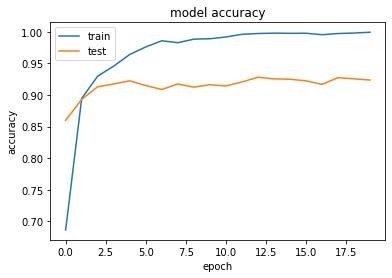

In [46]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

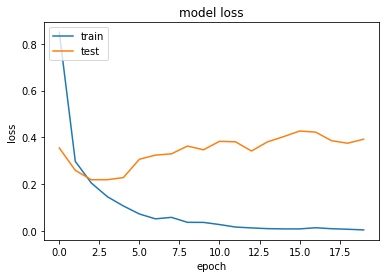

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()